## Распознавание текста в Yandex Cloud

Облако Yandex Cloud содержит множество сервисов для выполнения базовых операций, включая сервисы для распознавания печатного, рукописного и голосового текста. Посмотрим на примеры их использования.

> **ВНИМАНИЕ!!!** Для дальнейшей работы потребуются ключи для доступа к облаку: `folder_id` и `api_key`. Мы будем предполагать, что эти ключи записаны в секретах датасферы.

In [2]:
import os

folder_id  = os.environ['folder_id']
api_key = os.environ['api_key']

### Устанавливаем необходимые библиотеки

Для начала надо установить необходимые библиотеки Python, которые понадобятся нам в работе.

In [4]:
%pip install yandex-speechkit yandex-cloud-ml-sdk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


> **ВНИМАНИЕ!!!** После установки библиотек рекомендуется зайти в пункт меню **Kernel** -> **Restart Kernel**.

## Использование сервисов через REST API

Большинство сервисов доступных через вызовы REST и gRPC. Чтобы их использовать, надо уметь передавать запросы со специальными заголовками авторизации. Для этого опишем функции:


In [7]:
import requests
import os

def call_api(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.post(url, json=data, headers=headers).json()

def call_api_get(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.get(url, headers=headers).json()

### Распознаём текст на картинке

Для распознавания текста на картике служит сервис Yandex Vision OCR. Рассмотрим следующую картинку:

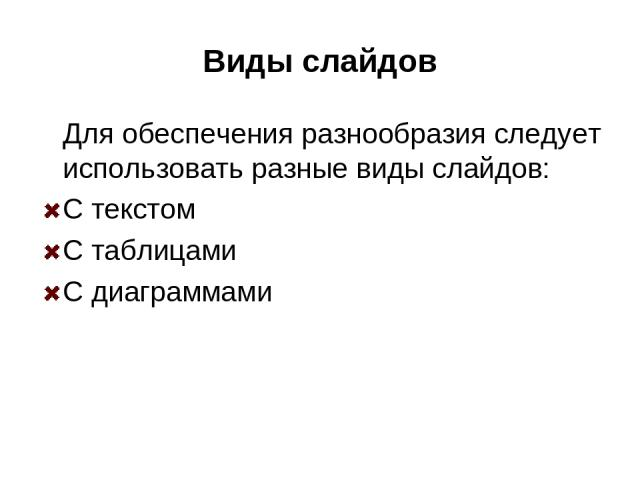

In [5]:
from PIL import Image

img = Image.open('images/slide.jpg')
img

Здесь для работы с картинками мы используем специальную библиотеку Python - PIL. Объект `Image` представляет собой картинку, которую можно считывать и записывать из файла, показывать и т.д.

Функция `ocr` ниже берёт такую картинку и возвращает результат распознавания текстовых объектов на ней:

In [8]:
from io import BytesIO
import base64

def ocr(img,languages=["*"],model="page"):
    buffer = BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()

    j = {
      "mimeType": "JPEG",
      "languageCodes": languages,
      "model": model,
      "content": base64.b64encode(myimage).decode('utf-8')
    }
    res = call_api("https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText",j)
    return res

ocr(img)

{'result': {'textAnnotation': {'width': '640',
   'height': '480',
   'blocks': [{'boundingBox': {'vertices': [{'x': '200', 'y': '53'},
       {'x': '200', 'y': '71'},
       {'x': '430', 'y': '71'},
       {'x': '430', 'y': '53'}]},
     'lines': [{'boundingBox': {'vertices': [{'x': '200', 'y': '53'},
         {'x': '200', 'y': '71'},
         {'x': '430', 'y': '71'},
         {'x': '430', 'y': '53'}]},
       'text': 'Виды слайдов',
       'words': [{'boundingBox': {'vertices': [{'x': '200', 'y': '51'},
           {'x': '200', 'y': '75'},
           {'x': '277', 'y': '75'},
           {'x': '277', 'y': '51'}]},
         'text': 'Виды',
         'entityIndex': '-1',
         'textSegments': [{'startIndex': '0', 'length': '4'}]},
        {'boundingBox': {'vertices': [{'x': '294', 'y': '51'},
           {'x': '294', 'y': '75'},
           {'x': '430', 'y': '75'},
           {'x': '430', 'y': '51'}]},
         'text': 'слайдов',
         'entityIndex': '-1',
         'textSegments': [{'s

Чтобы получить только текст, используем такой вариант:

In [18]:
def ocr_text(img,**kwargs):
    res = ocr(img,**kwargs)
    return res['result']['textAnnotation']['fullText']

txt = ocr_text(img)
print(txt)

Виды слайдов
Для обеспечения разнообразия следует
использовать разные виды слайдов:
×С текстом
×С таблицами
×С диаграммами



Попробуем распознать рукописный текст:

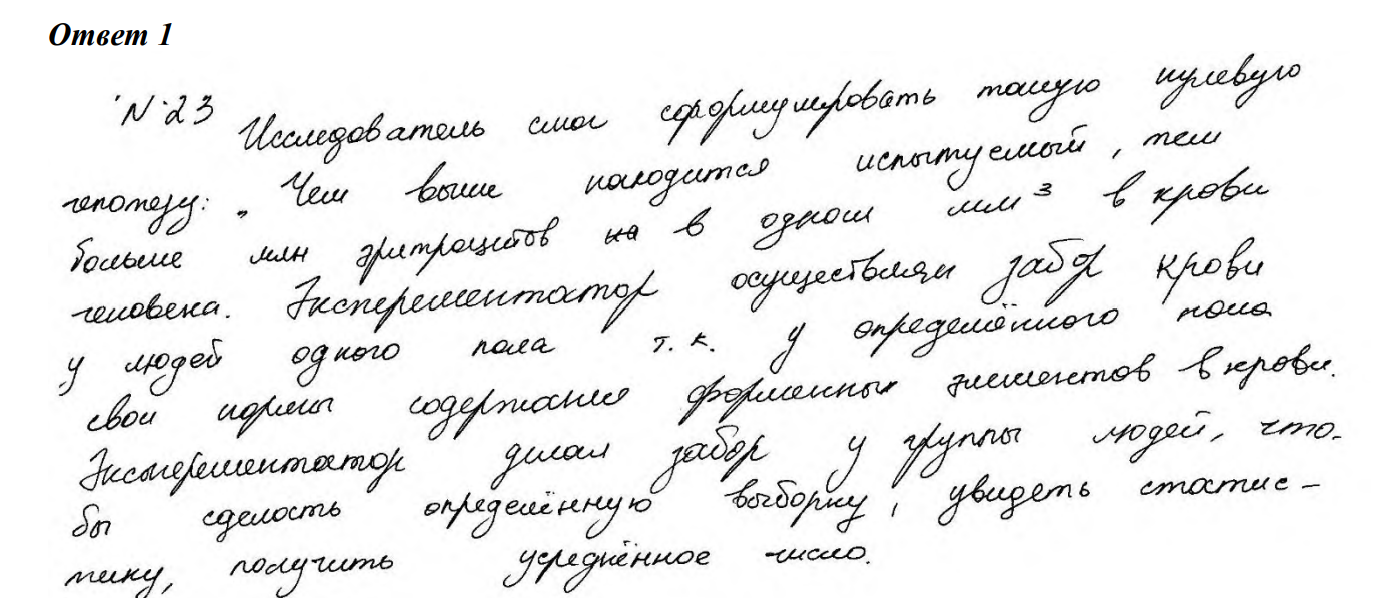

In [13]:
img_hw = Image.open("images/biology-1.png").convert("RGB")
img_hw

Для распознавания рукописного текста надо передать правильную модель и язык:

In [19]:
txt_hw = ocr_text(img_hw,model="handwritten",languages=['ru'])
txt_hw

'Ответ 1\n№23 Исследователь смое сордрмумровать толую кулевую\nчепотезу: Чем выше находится испытуемый , тем\nбольше млн эритроцитов на в одном м\nв крови\nгеловека. Эксперементатор осуществлям забд крови\nу людей одного пола\n7. к. у определенного\nсвои иормы содержание форменны злементов в крови.\nУкстерементатор делал забор у группы людей, что-\nбы\nсделость определённую выборку, увидеть стостие-\nполучить\nусреднённое число.\n'

Видно, что качество текста не на высоте :( Попробуем использовать Yandex GPT для пост-обработки текста :

In [20]:
from yandex_cloud_ml_sdk import YCloudML

sdk = YCloudML(folder_id=folder_id,auth=api_key)

def gpt(messages,
        system_message=None,
        model="yandexgpt", model_version="rc",
        return_text=True,
        return_json=False):
    if isinstance(messages,str):
        messages = [{ "role" : "user", "text" : messages }]
        if system_message is not None:
            messages.insert(0, { "role" : "system", "text" : system_message })
    model = sdk.models.completions(model,model_version=model_version)
    if return_json:
        model = model.configure(response_format='json')
    res = model.run(messages)
    res = res.alternatives[0]
    return res.text if return_text else res

In [22]:
prompt = """Ты - научный редактор. Тебе на вход подаётся текст в тройных обратных кавычках, 
распознанный из рукописного текста. Пожалуйста, приведи этот текст, исправть все опечатки и ошибки,
возникшие в результате распознавания. Не дополняй текст, не добавляй ничего лишнего и не исключай.
Результат должен быть максимально близок к исходному тексту, но с исправленными ошибками.
Текст: ```{}```
"""

res = gpt(prompt.format(txt_hw))
print(res)

Ответ 1

№23 Исследователь сформулировал основную гипотезу: чем выше находится испытуемый, тем больше млн эритроцитов в одном м³ крови человека. Экспериментатор осуществлял забор крови у людей одного пола, так как у определённого пола свои нормы содержания форменных элементов в крови. Экспериментатор делал забор у группы людей, чтобы сделать определённую выборку, увидеть состояние и получить усреднённое число.


Мы также можем более красиво отформатировать текст, распознанный со слайда:

In [23]:
prompt = """Ты - научный редактор. Тебе на вход подаётся текст в тройных обратных кавычках, распознанный 
со слайдов презентации. Пожалуйста, приведи этот текст в аккуратный вид и представь его в формате Markdown.
Текст: ```{}```
"""

res = gpt(prompt.format(txt))
print(res)

### Виды слайдов

Для обеспечения разнообразия следует использовать разные виды слайдов:

- с текстом;
- с таблицами;
- с диаграммами.
